## Hough Transform for Line Detection

Here we demonstrate an implementation of the Hough Transform for detecting lines in images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


## Generating Random Points

We generate a set of random points in the first quadrant.
These points will be used as input data for the Hough Transform.


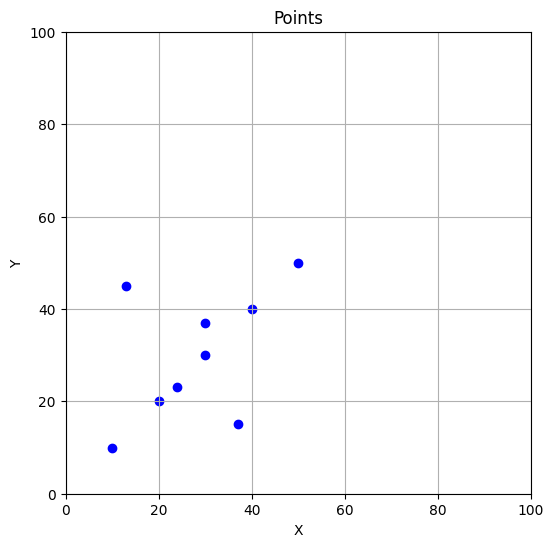

In [37]:

num_points = 20  # Number of points
x_max = 100      # max x value
y_max = 100      # max y value

# # np.random.seed(37317)
# x_points = np.random.uniform(0, x_max, num_points)
# y_points = np.random.uniform(0, y_max, num_points)
x_points = [10,20,30,40,50,24,13,37,30]
y_points = [10,20,30,40,50,23,45,15,37]



plt.figure(figsize=(6, 6))
plt.scatter(x_points, y_points, color='blue')
plt.xlim(0, x_max)
plt.ylim(0, y_max)
plt.title('Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


## Hough Transform Implementation

We apply the Hough Transform to the generated points to detect lines as intersections in the parameter space.


In [38]:
def hough_line_points(x_points, y_points, angle_step=1, rho_step=1):
    """
    Hough transform on a set of points.

    Input:
    x_points - x-coordinates of the points
    y_points - y-coordinates
    angle_step - Spacing between angles in degrees. Default is 1.
    rho_step - Spacing between rho values. Default is 1.

    Returns:
    accumulator - 2D array of the hough transform accumulator
    thetas - Array of angles used in computation, in radians
    rhos - Array of rho values
    """
    # ranges for Rho and Theta
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    diag_len = int(np.ceil(np.sqrt(x_max**2 + y_max**2)))
    rhos = np.arange(-diag_len, diag_len + rho_step, rho_step)  # Ensure rhos covers the entire range

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    num_rhos = len(rhos)

    # Accumulator matrix
    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.int64)

    # Votes for the accumulator
    for i in range(len(x_points)):
        x = x_points[i]
        y = y_points[i]
        for t_idx in range(num_thetas): # More efficient, we don't really need to go through all A[] entries,
            single_rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))# for a given, angle, we vote in a single theta,tho position.
            rho_idx = int((single_rho + diag_len) / rho_step)  # Adjust rho_idx based on rho_step
            if 0 <= rho_idx < num_rhos:
                accumulator[rho_idx, t_idx] += 1

    return accumulator, thetas, rhos


## Visualizing the Hough Transform

Visualization of the accumulator matrix to show the parameter space that correspond to lines.


In [39]:
def plot_hough_accumulator(accumulator, thetas, rhos):
    plt.figure(figsize=(10, 10))
    plt.imshow(
        accumulator, cmap='hot', 
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]]
    )
    plt.title('Hough Transform Accumulator')
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Rho (pixels)')
    plt.grid(True)
    plt.colorbar()
    plt.show()


## Apply Hough Transform and Visualize Results

Now we use the Hough Transform on the random set of points and visualize it.


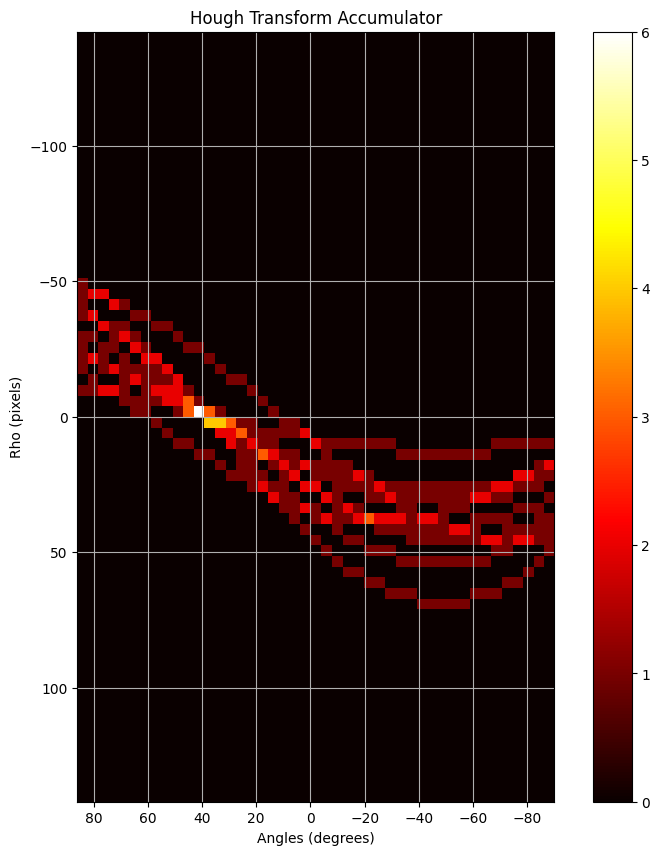

In [40]:
angle_step, rho_step = 4,4
accumulator, thetas, rhos = hough_line_points(x_points, y_points,angle_step, rho_step)
plot_hough_accumulator(accumulator, thetas, rhos)

## Comparing Different Levels of Discretization

We can compare the Hough Transform results with different levels of discretization:


In [41]:
# discretizations = [(0.2, 0.2), (0.5, 0.5), (0.8, 0.8), (1, 1), (1.5, 1.5)]

# for angle_step, rho_step in discretizations:
#     print(f"Angle Step: {angle_step} degrees, Rho Step: {rho_step} pixels")
#     accumulator, thetas, rhos = hough_line_points(x_points, y_points, angle_step, rho_step)
#     plot_hough_accumulator(accumulator, thetas, rhos)


## plotting with the lines

In [42]:
def get_hough_lines(accumulator, thetas, rhos, num_lines):
    """
    Find most prominent lines in accumulator.

    Parameters:
    accumulator - The Accumulator matrix.
    thetas - Array of angles.
    rhos - Array of rhos.
    num_lines - Number of lines wanted.

    Returns:
    lines - A list of (rho, theta) tuples representing the detected lines.
    """
    lines = []
    accumulator_copy = accumulator.copy()  # Work on a copy to avoid modifying the original
    for _ in range(num_lines):
        idx = np.argmax(accumulator_copy)
        rho_idx, theta_idx = np.unravel_index(idx, accumulator_copy.shape)
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        lines.append((rho, theta))
        # delete local maxima to find the next one
        accumulator_copy[rho_idx, theta_idx] = 0

    return lines


In [45]:
def plot_lines_on_points(x_points, y_points, lines, x_max, y_max):
    plt.figure(figsize=(6, 6))
    plt.scatter(x_points, y_points, color='blue', label='Points')

    for rho, theta in lines:
        # Convert rho, theta representation back to cartesian representation
        if np.sin(theta) != 0:  # to not divide by zero
            x_vals = np.array([0, x_max])
            y_vals = (rho - x_vals * np.cos(theta)) / np.sin(theta)
            plt.plot(x_vals, y_vals, color='red', linestyle='--', label=f'rho={rho:.2f}, theta={np.rad2deg(theta):.1f}°')

    plt.xlim(0, x_max)
    plt.ylim(0, y_max)
    plt.title('Detected Lines and Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    plt.show()


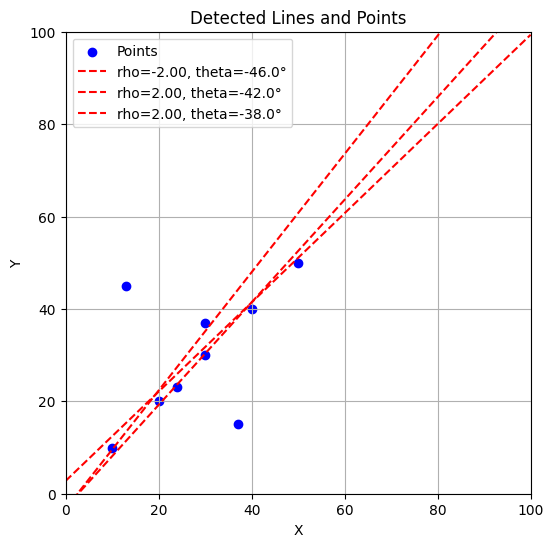

In [46]:
# Extract most prominent lines from the accumulator
num_lines = 3 # Number of lines to extract
lines = get_hough_lines(accumulator, thetas, rhos, num_lines)

# plot detected lines
plot_lines_on_points(x_points, y_points, lines, x_max=x_max, y_max=y_max)


## Great!!

## Now working on a real image

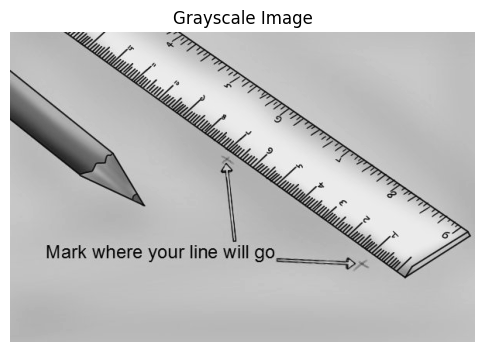

In [47]:
    from skimage import io, color
    import matplotlib.pyplot as plt
    import numpy as np

    image = io.imread('pics/ruler.bmp')

    # check if the image has an alpha channel (4 channels) and maybe remove it
    if image.shape[-1] == 4:
        image = image[..., :3]

    # convert the image to grayscale
    gray_image = color.rgb2gray(image)

    plt.figure(figsize=(6, 6))
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()





## creating an edge points

## Canny edge points algorithm!

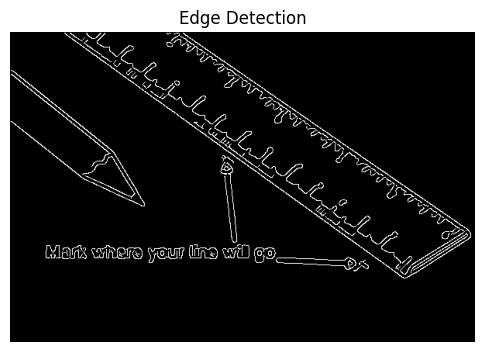

In [68]:
from skimage import feature

edges = feature.canny(gray_image, sigma=2.0)
edges_flipped = np.flipud(edges)
image_flipped = np.flipud(image)

# Display the edges
plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')
plt.show()

## Hough transform on these points

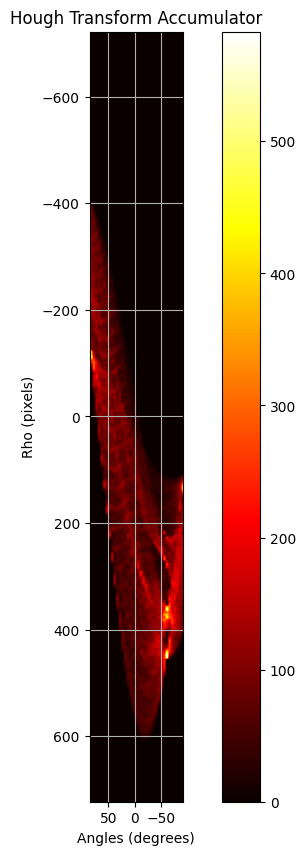

In [80]:
y_points, x_points = np.nonzero(edges_flipped)
angle_step, rho_step = 5, 5
accumulator, thetas, rhos = hough_line_points(x_points, y_points, angle_step, rho_step)
plot_hough_accumulator(accumulator, thetas, rhos)

## Show it all on the picture

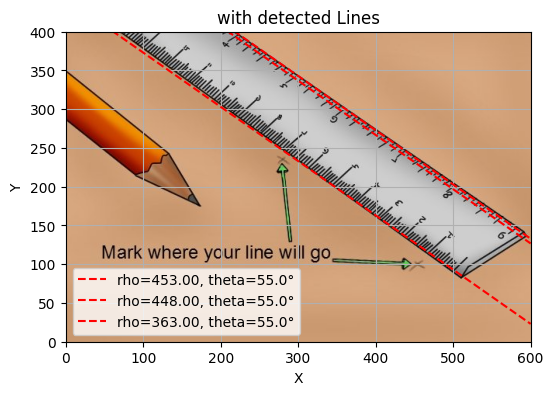

In [85]:
# Extract the most prominent lines from the accumulator
num_lines = 3  # Adjust the number of lines to detect
lines = get_hough_lines(accumulator, thetas, rhos, num_lines)

x_max, y_max = gray_image.shape[1], gray_image.shape[0]
plot_lines_on_image(image_flipped, lines, x_max, y_max)


## show on image